In [43]:
import numpy as np
from numpy import sqrt
np.set_printoptions(precision=5, suppress=True)
plt.rc('text', usetex=True)


In [288]:

q1 = np.array([0, 1])
q2 = np.array([-sqrt(3)/2, -1/2])
q3 = np.array([sqrt(3)/2, -1/2])

class KM():
    # This class implements the triangular model, i.e. centered at the K point of the Moire BZ.
    # I consider there to be alternating A and B shells, where the first point at the center is not in a shell,
    # then the first A shell has 3 points, the first B shell has 6 points, the second A shell has 9 points, etc.
    # So in general the ith A shell has 6i-3 points, and the ith B shell has 6i points.


    q1 = np.array([0, 1])
    q2 = np.array([-sqrt(3)/2, -1/2])
    q3 = np.array([sqrt(3)/2, -1/2])

    @staticmethod
    def rotate_60i(v, i):
        c = np.cos(i*np.pi/3)
        s = np.sin(i*np.pi/3)
        return np.array([c*v[0] - s*v[1], s*v[0] + c*v[1]])

    @staticmethod
    def dotsigma(v):
        sigmax = np.array([[0, 1], [1, 0]])
        sigmay = np.array([[0, -1j], [1j, 0]])
        return v[0] * sigmax + v[1] * sigmay
    
    @staticmethod
    def Tj(j, w0, w1):
        # The T matrices in BSRL are hermitian.
        sigma0 = np.identity(2)
        sigmax = np.array([[0, 1], [1, 0]])
        sigmay = np.array([[0, -1j], [1j, 0]])
        return w0 * sigma0 + w1 * (np.cos(2*np.pi*(j-1)/3) * sigmax + np.sin(2*np.pi*(j-1)/3) * sigmay)

    # In the following site indexing scheme, {n, m, j} are all 1-based.
    @staticmethod
    def QA_site(n, m, p, j):
        # n is which A shell, m is 3-way rotation within the A shell, and p is a parity index (1 or 2) of whether the site
        # is among the first __ or last __ of the __ sites in one of the three rotations. 
        # The A shell is more complicated than B shells because we don't have full 6-fold symmetry between the sites.
        # So for p=1, j ranges from 1 to n-1. For p=2, j ranges from 1 to n.
        if p == 1:
            QA_n_m1_p1_j1 = (n-1) * (q1 - q2) + q1
            QA_n_m1_p1_jgen = QA_n_m1_p1_j1 + (j-1) * (q2 - q3)
            QA_n_mgen_p1_jgen = KM.rotate_60i(QA_n_m1_p1_jgen, 2*(m-1))
            return QA_n_mgen_p1_jgen
        if p == 2:
            QA_n_m1_p2_j1 = (n-1) * (q1 - q3) + q1
            QA_n_m1_p2_jgen = QA_n_m1_p2_j1 + (j-1) * (q2 - q1)
            QA_n_mgen_p2_jgen = KM.rotate_60i(QA_n_m1_p2_jgen, 2*(m-1))
            return QA_n_mgen_p2_jgen
            
    @staticmethod
    def QB_site(n, m, p, j):
        # To follow the conventions in QA_site, we use m = 1, 2, 3 and p = 1, 2.
        # n is which B shell, m is rotation within the B shell, and j ranges from 1 to n.
        QB_n_m1_p1_j1 = n * (q1 - q2)
        QB_n_m1_p1_jgen = QB_n_m1_p1_j1 + (j-1) * (q2 - q3)
        # rotation of 2*m + p - 3 so that m=1, p=1 gives no rotation, m=3, p=2 gives rotation of 5*60deg, etc
        QB_n_mgen_pgen_jgen = KM.rotate_60i(QB_n_m1_p1_jgen, 2*m + p - 3) 
        return QB_n_mgen_pgen_jgen



    # It'll be natural to describe hoppings between layers from the perspective of the B layers.


    # The next two functions return the 1-indexed order that the site is in.
    # Order is 
    #  1. Center

    #  2. A(n1, m1, p2, j1)
    #  3. A(n1, m2, p2, j1)
    #  4. A(n1, m3, p2, j1)

    #  5. B(n1, m1, p1, j1)
    #  6. B(n1, m1, p2, j1)
    #  7. B(n1, m2, p1, j1)
    #  8. B(n1, m2, p2, j1)
    #  9. B(n1, m3, p1, j1)
    # 10. B(n1, m3, p2, j1)

    # 11. A(n2, m1, p1, j1)
    # 12. A(n2, m1, p2, j1)
    # 13. A(n2, m1, p2, j2)
    # 14. A(n2, m2, p1, j1)
    # 15. A(n2, m2, p2, j1)
    # 16. A(n2, m2, p2, j2)
    # 17. A(n2, m3, p1, j1)
    # 18. A(n2, m3, p2, j1)
    # 19. A(n2, m3, p2, j2)

    # 20. B(n2, m1, p1, j1)
    # 21. B(n2, m1, p1, j2)
    # 22. B(n2, m1, p2, j1)
    # 23. B(n2, m1, p2, j2)
    # 24. B(n2, m2, p1, j1)
    # 25. B(n2, m2, p1, j2)
    # 26. B(n2, m2, p2, j1)
    # 27. B(n2, m2, p2, j2)
    # 28. B(n2, m3, p1, j1)
    # 29. B(n2, m3, p1, j2)
    # 30. B(n2, m3, p2, j1)
    # 31. B(n2, m3, p2, j2)


    @staticmethod
    def get_site_index_A(n, m, p, j):
        num_sites_prev_shells = 1 + 3 * ((n-1) * (2*(n-1) + 1))
        num_sites_prev_rotations_within_shell = (m-1) * (2*n - 1)
        num_sites_prev_parity = (p-1) * (n-1)
        num_sites_remaining = j
        return num_sites_prev_shells + num_sites_prev_rotations_within_shell + \
            num_sites_prev_parity + num_sites_remaining

    @staticmethod
    def get_site_index_B(n, m, p, j):
        if n == 0: # handles the center site
            return 1
        num_sites_prev_shells = 1 + 3 * ((n-1) * (2*(n-1) + 1)) + (6*n - 3)
        index_within_shell = n * (2*m + p - 3) + j
        return num_sites_prev_shells + index_within_shell



    @staticmethod
    def create_site_plot(nshell, fontsize=10):
        # A color: RGB = 250 70 22
        # B color: RGB = 0 33 165
        # colorA = (250/255, 70/255, 22/255)
        # colorB = (0/255, 33/255, 165/255)
        colorA = np.array((1.0, 0.647, 0.0))
        colorB = 0.7*np.array((0.392, 0.584, 0.929))


        import matplotlib.pyplot as plt
        nBshell = nshell//2
        nAshell = nshell - nBshell
        fig, ax = plt.subplots(dpi=300) # figsize=(3, 3))

        
        hops = []
        styles = []

        # 1 in solid, 2 in dotted, 3 in dashed
        orientation_to_style = {1: 'solid', 2: 'dotted', 3: 'dashed'}

        # Setting up H_An_Bn terms
        for n in range(1, nBshell + 1):
            for m in range(1, 4):
                p = 1
                for j in range(1, n+1):
                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n, m, p, j)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[m % 3 + 1])

                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n, m, p, j+1)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[(m+1) % 3 + 1])

                p = 2
                for j in range(2, n+1):
                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n, m, p, j)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[(m+1) % 3 + 1])


        # Setting up H_Bn-1_An terms
        # This will also handle the center to first A layer. 
        for n in range(1, nAshell + 1):
            for m in range(1, 4):
                p = 1
                for j in range(1, n+1):
                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n-1, m, p, j)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[m])

                p = 2
                for j in range(2, n+1):
                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n-1, m, p, j-1)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[m % 3 + 1])

                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n-1, m, p, j)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[m])
        
        for i in range(len(hops)):
            hop = hops[i]
            style = styles[i]
            ax.plot([hop[0][0], hop[1][0]], [hop[0][1], hop[1][1]], c='0.5', linestyle=style)




        # Drawing dots and labels at sites
        ax.plot(0, 0, 'o', color=colorB)

        for n in range(1, nAshell + 1):
            for m in range(1, 4):
                p = 1
                for j in range(1, n):
                    loc = KM.QA_site(n, m, p, j)
                    ax.plot(loc[0], loc[1], 'o', color=colorA)
                    ax.text(loc[0], loc[1], f"$A_{{{n},{m},{p},{j}}}$", fontsize=fontsize, verticalalignment='center', horizontalalignment='center')
                p = 2
                for j in range(1, n+1):
                    loc = KM.QA_site(n, m, p, j)
                    ax.plot(loc[0], loc[1], 'o', color=colorA)
                    ax.text(loc[0], loc[1], f"$A_{{{n},{m},{p},{j}}}$", fontsize=fontsize, verticalalignment='center', horizontalalignment='center')
        
        for n in range(1, nBshell + 1):
            for m in range(1, 4):
                for p in range(1, 3):
                    for j in range(1, n+1):
                        loc = KM.QB_site(n, m, p, j)
                        ax.plot(loc[0], loc[1], 'o', color=colorB)
                        ax.text(loc[0], loc[1], f"$B_{{{n},{m},{p},{j}}}$", fontsize=fontsize, verticalalignment='center', horizontalalignment='center')

        ax.plot(0, 0, 'o', color='0.2')
        ax.text(0, 0, "$K_M$", fontsize=fontsize)# , verticalalignment='center', horizontalalignment='center')
        # need to figure out where the Gamma and M points are


        ax.set_aspect('equal')

        plt.show()





    @staticmethod
    def create_site_plot_numbered(nshell, fontsize=10):
        # A color: RGB = 250 70 22
        # B color: RGB = 0 33 165
        # colorA = (250/255, 70/255, 22/255)
        # colorB = (0/255, 33/255, 165/255)
        colorA = np.array((1.0, 0.647, 0.0))
        colorB = 0.7*np.array((0.392, 0.584, 0.929))


        import matplotlib.pyplot as plt
        nBshell = nshell//2
        nAshell = nshell - nBshell
        fig, ax = plt.subplots(dpi=150) # figsize=(3, 3))

        
        hops = []
        styles = []

        # 1 in solid, 2 in dotted, 3 in dashed
        orientation_to_style = {1: 'solid', 2: 'dotted', 3: 'dashed'}

        # Setting up H_An_Bn terms
        for n in range(1, nBshell + 1):
            for m in range(1, 4):
                p = 1
                for j in range(1, n+1):
                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n, m, p, j)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[m % 3 + 1])

                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n, m, p, j+1)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[(m+1) % 3 + 1])

                p = 2
                for j in range(2, n+1):
                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n, m, p, j)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[(m+1) % 3 + 1])


        # Setting up H_Bn-1_An terms
        # This will also handle the center to first A layer. 
        for n in range(1, nAshell + 1):
            for m in range(1, 4):
                p = 1
                for j in range(1, n+1):
                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n-1, m, p, j)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[m])

                p = 2
                for j in range(2, n+1):
                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n-1, m, p, j-1)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[m % 3 + 1])

                    site_A = KM.QA_site(n, m, p, j)
                    site_B = KM.QB_site(n-1, m, p, j)
                    hops.append((site_A, site_B))
                    styles.append(orientation_to_style[m])
        
        for i in range(len(hops)):
            hop = hops[i]
            style = styles[i]
            ax.plot([hop[0][0], hop[1][0]], [hop[0][1], hop[1][1]], c='0.5', linestyle=style)




        # Drawing dots and labels at sites
        ax.plot(0, 0, 'o', color=colorB)

        for n in range(1, nAshell + 1):
            for m in range(1, 4):
                p = 1
                for j in range(1, n):
                    loc = KM.QA_site(n, m, p, j)
                    ax.plot(loc[0], loc[1], 'o', color=colorA)
                    # ax.text(loc[0], loc[1], f"$A_{{{n},{m},{p},{j}}}$", fontsize=fontsize, verticalalignment='center', horizontalalignment='center')
                    number = KM.get_site_index_A(n, m, p, j)
                    ax.text(loc[0], loc[1], f"{number}", fontsize=fontsize, verticalalignment='center', horizontalalignment='center')
                p = 2
                for j in range(1, n+1):
                    loc = KM.QA_site(n, m, p, j)
                    ax.plot(loc[0], loc[1], 'o', color=colorA)
                    # ax.text(loc[0], loc[1], f"$A_{{{n},{m},{p},{j}}}$", fontsize=fontsize, verticalalignment='center', horizontalalignment='center')
                    number = KM.get_site_index_A(n, m, p, j)
                    ax.text(loc[0], loc[1], f"{number}", fontsize=fontsize, verticalalignment='center', horizontalalignment='center')
        
        for n in range(1, nBshell + 1):
            for m in range(1, 4):
                for p in range(1, 3):
                    for j in range(1, n+1):
                        loc = KM.QB_site(n, m, p, j)
                        ax.plot(loc[0], loc[1], 'o', color=colorB)
                        # ax.text(loc[0], loc[1], f"$B_{{{n},{m},{p},{j}}}$", fontsize=fontsize, verticalalignment='center', horizontalalignment='center')
                        number = KM.get_site_index_B(n, m, p, j)
                        ax.text(loc[0], loc[1], f"{number}", fontsize=fontsize, verticalalignment='center', horizontalalignment='center')

        ax.plot(0, 0, 'o', color='0.2')
        ax.text(0, 0, "$K_M$", fontsize=fontsize)# , verticalalignment='center', horizontalalignment='center')
        # need to figure out where the Gamma and M points are


        ax.set_aspect('equal')

        plt.show()


    
    @staticmethod
    def BZ(N, proportion=1):
        # Generates a list of points within the MBZ centered at 0, whatever 0 is.
        # Creates a point at the center, six at the corners,
        # and has N points between the center and each corner, including the corner and excluding the center.
        # The hexagonal BZ is oriented with pointy ends up and down, following the convention in BSRL1.abs
        # proportion > 1 scales the region so that it covers more than just the MBZ. proportion < 1 zooms in on Gamma_M

        # First, generate the points in a sextant. Then, make five more copies. 
        # Starting with the eastern sextant. 

        assert N >= 1

        q1N = np.array([0, 1]) / N * proportion
        q3N = np.array([sqrt(3)/2, -1/2]) / N * proportion

        east_points = []
        for i in range(1, N+1):
            for j in range(i):
                east_points.append(i*q3N + j*q1N)


        all_points = [np.array([0, 0])]
        # Now making the other copies.
        def rotate_60ccw(v):
            c = np.cos(np.pi/3)
            s = np.sin(np.pi/3)
            return np.array([c*v[0] - s*v[1], s*v[0] + c*v[1]])

        for point in east_points:
            all_points.append(point)
            for i in range(5):
                all_points.append(rotate_60ccw(all_points[-1]))
        
        return all_points



    @staticmethod
    def get_KM_matrix(k, w0, w1, nshell):
        nBshell = nshell//2
        nAshell = nshell - nBshell

        dim = 2 + 3 * nshell * (nshell+1)
        mat = np.zeros((dim, dim), dtype=complex)

        T1 = KM.Tj(1, w0, w1)
        T2 = KM.Tj(2, w0, w1)
        T3 = KM.Tj(3, w0, w1)

        ### Setting up Dirac Hamiltonians. #######
        # set up center Dirac Hamiltonian
        submat = KM.dotsigma(k)
        mat[0:2, 0:2] = submat

        # set up H_kAn terms:
        for n in range(1, nAshell + 1):
            for m in range(1, 4):
                p = 1
                for j in range(1, n):
                    site_index = KM.get_site_index_A(n, m, p, j)
                    s = 2*site_index - 2
                    submat = KM.dotsigma(k - KM.QA_site(n, m, p, j))
                    mat[s:s+2, s:s+2] = submat
                p = 2
                for j in range(1, n+1):
                    site_index = KM.get_site_index_A(n, m, p, j)
                    s = 2*site_index - 2
                    submat = KM.dotsigma(k - KM.QA_site(n, m, p, j))
                    mat[s:s+2, s:s+2] = submat

        # set up H_kBn terms:
        for n in range(1, nBshell + 1):
            for m in range(1, 4):
                for p in range(1, 3):
                    for j in range(1, n+1):
                        site_index = KM.get_site_index_B(n, m, p, j)
                        s = 2*site_index - 2
                        submat = KM.dotsigma(k - KM.QB_site(n, m, p, j))
                        mat[s:s+2, s:s+2] = submat
        ### End of setting up Dirac Hamiltonians. #######


        ### Setting up hopping terms. ######
        # set up H_An_Bn terms:
        # vertical is T1, downleft is T2, downright is T3
        # doing it from the perspective of A sites
        submats = {1: T1, 2: T2, 3: T3}
        for n in range(1, nBshell + 1):
            for m in range(1, 4):
                p = 1
                for j in range(1, n+1):
                    site_index_A = KM.get_site_index_A(n, m, p, j)
                    site_index_B = KM.get_site_index_B(n, m, p, j)
                    sA = 2*site_index_A - 2
                    sB = 2*site_index_B - 2
                    submat = submats[m % 3 + 1]
                    mat[sA:sA+2, sB:sB+2] = submat
                    mat[sB:sB+2, sA:sA+2] = submat

                    site_index_A = KM.get_site_index_A(n, m, p, j)
                    site_index_B = KM.get_site_index_B(n, m, p, j+1)
                    sA = 2*site_index_A - 2
                    sB = 2*site_index_B - 2
                    submat = submats[(m+1) % 3 + 1]
                    mat[sA:sA+2, sB:sB+2] = submat
                    mat[sB:sB+2, sA:sA+2] = submat

                p = 2
                for j in range(2, n+1):
                    site_index_A = KM.get_site_index_A(n, m, p, j)
                    site_index_B = KM.get_site_index_B(n, m, p, j)
                    sA = 2*site_index_A - 2
                    sB = 2*site_index_B - 2
                    submat = submats[(m+1) % 3 + 1]
                    mat[sA:sA+2, sB:sB+2] = submat
                    mat[sB:sB+2, sA:sA+2] = submat

        # Setting up H_Bn-1_An terms
        # This will also handle the center to first A layer. 
        for n in range(1, nAshell + 1):
            for m in range(1, 4):
                p = 1
                for j in range(1, n+1):
                    site_index_A = KM.get_site_index_A(n, m, p, j)
                    site_index_B = KM.get_site_index_B(n-1, m, p, j)
                    sA = 2*site_index_A - 2
                    sB = 2*site_index_B - 2
                    submat = submats[m]
                    mat[sA:sA+2, sB:sB+2] = submat
                    mat[sB:sB+2, sA:sA+2] = submat

                p = 2
                for j in range(2, n+1):
                    site_index_A = KM.get_site_index_A(n, m, p, j)
                    site_index_B = KM.get_site_index_B(n-1, m, p, j-1)
                    sA = 2*site_index_A - 2
                    sB = 2*site_index_B - 2
                    submat = submats[m % 3 + 1]
                    mat[sA:sA+2, sB:sB+2] = submat
                    mat[sB:sB+2, sA:sA+2] = submat

                    site_index_A = KM.get_site_index_A(n, m, p, j)
                    # site_index_B = KM.get_site_index_B(n-1, m, p, j)   ##### PROBLEMATIC!!!!!!!!
                    if m == 3 and j == n:
                        site_index_B = KM.get_site_index_B(n-1, 1, 1, 1) 
                    else:
                        site_index_B = KM.get_site_index_B(n-1, m, p, j)
                    sA = 2*site_index_A - 2
                    sB = 2*site_index_B - 2
                    submat = submats[m]
                    mat[sA:sA+2, sB:sB+2] = submat
                    mat[sB:sB+2, sA:sA+2] = submat
        
        ### End setting up hopping terms. ######
        return mat





    @staticmethod
    def plot_path_eigvals_colormap(N, w0, w1, nshell_range, Elimits=None, bands=None, colormap='viridis'):
        """
        Plots eigenvalues for multiple shells on the same plot, using a colormap for line colors.

        Parameters:
            N (int): Number of k-points along the path in the BZ.
            w0 (float): Parameter in the Hamiltonian.
            w1 (float): Parameter in the Hamiltonian.
            nshell_range (list or range): Range of shells to plot.
            Elimits (tuple): (Emin, Emax) tuple to set the y-axis limits.
            bands (tuple): (num_bands_above, num_bands_below) to specify bands to plot.
            colormap (str): Name of the matplotlib colormap to use.
        """
        fig, ax = plt.subplots(dpi=300)
        cmap = get_cmap(colormap)


        path = []
        for i in range(N):
            path.append((1 - i / N) * q1 + (i / N) * 0)
        for i in range(N):
            path.append((1 - i / N) * 0 + (i / N) * (-q1))
        for i in range(int(N * sqrt(3))):
            path.append((1 - i / (N * sqrt(3))) * (-q1) + (i / (N * sqrt(3))) * (-q3))
        for i in range(N):
            path.append((1 - i / N) * (-q3) + (i / N) * q1)

        
        for nshell in nshell_range:
            all_eigvals = []
            for k in path:
                all_eigvals.append(sorted(np.linalg.eigvalsh(KM.get_KM_matrix(k, w0, w1, nshell))))

            total_num_bands = len(all_eigvals[0])
            if bands:
                which_eigvals_to_plot = range(total_num_bands//2 - bands[1], total_num_bands//2 + bands[0])
            else: 
                which_eigvals_to_plot = range(total_num_bands)
            eigvals_to_plot = np.array(all_eigvals)[:, which_eigvals_to_plot]

            # Normalize nshell for colormap indexing
            color = cmap((nshell - min(nshell_range)) / (max(nshell_range) - min(nshell_range)))

            for i in range(len(eigvals_to_plot[0])):
                ax.plot(eigvals_to_plot[:, i], color=color, label=f"{nshell} shells" if i == 0 else "")

        if Elimits:
            ax.set_ylim(Elimits)


        k_labels = ["$q_1$", "$0$", "$-q_1$", "$-q_3$", "$q_1$"]
        k_points = [0, N, 2 * N, 2 * N + int(N * sqrt(3)), 3 * N + int(N * sqrt(3))]

        ax.set_xticks(k_points)
        ax.set_xticklabels(k_labels, fontsize=15)
        ax.set_xlabel("$k$", fontsize=15)

        # Add dashed vertical lines for labeled points
        for k in k_points:
            ax.axvline(k, color='gray', linestyle='dashed', linewidth=0.8)

        # Add a colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(nshell_range), vmax=max(nshell_range)))
        sm.set_array([])
        # cbar = plt.colorbar(sm, ax=ax)
        # cbar.set_label('Shell Index')

        plt.title(f"Eigenvalues along path in MBZ for $w_0 = {w0:.4f}$, $w_1 = {w1:.4f}$")
        plt.legend(loc='upper right', fontsize='small', ncol=1)
        plt.show()


/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_18922/3951392895.py:533: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



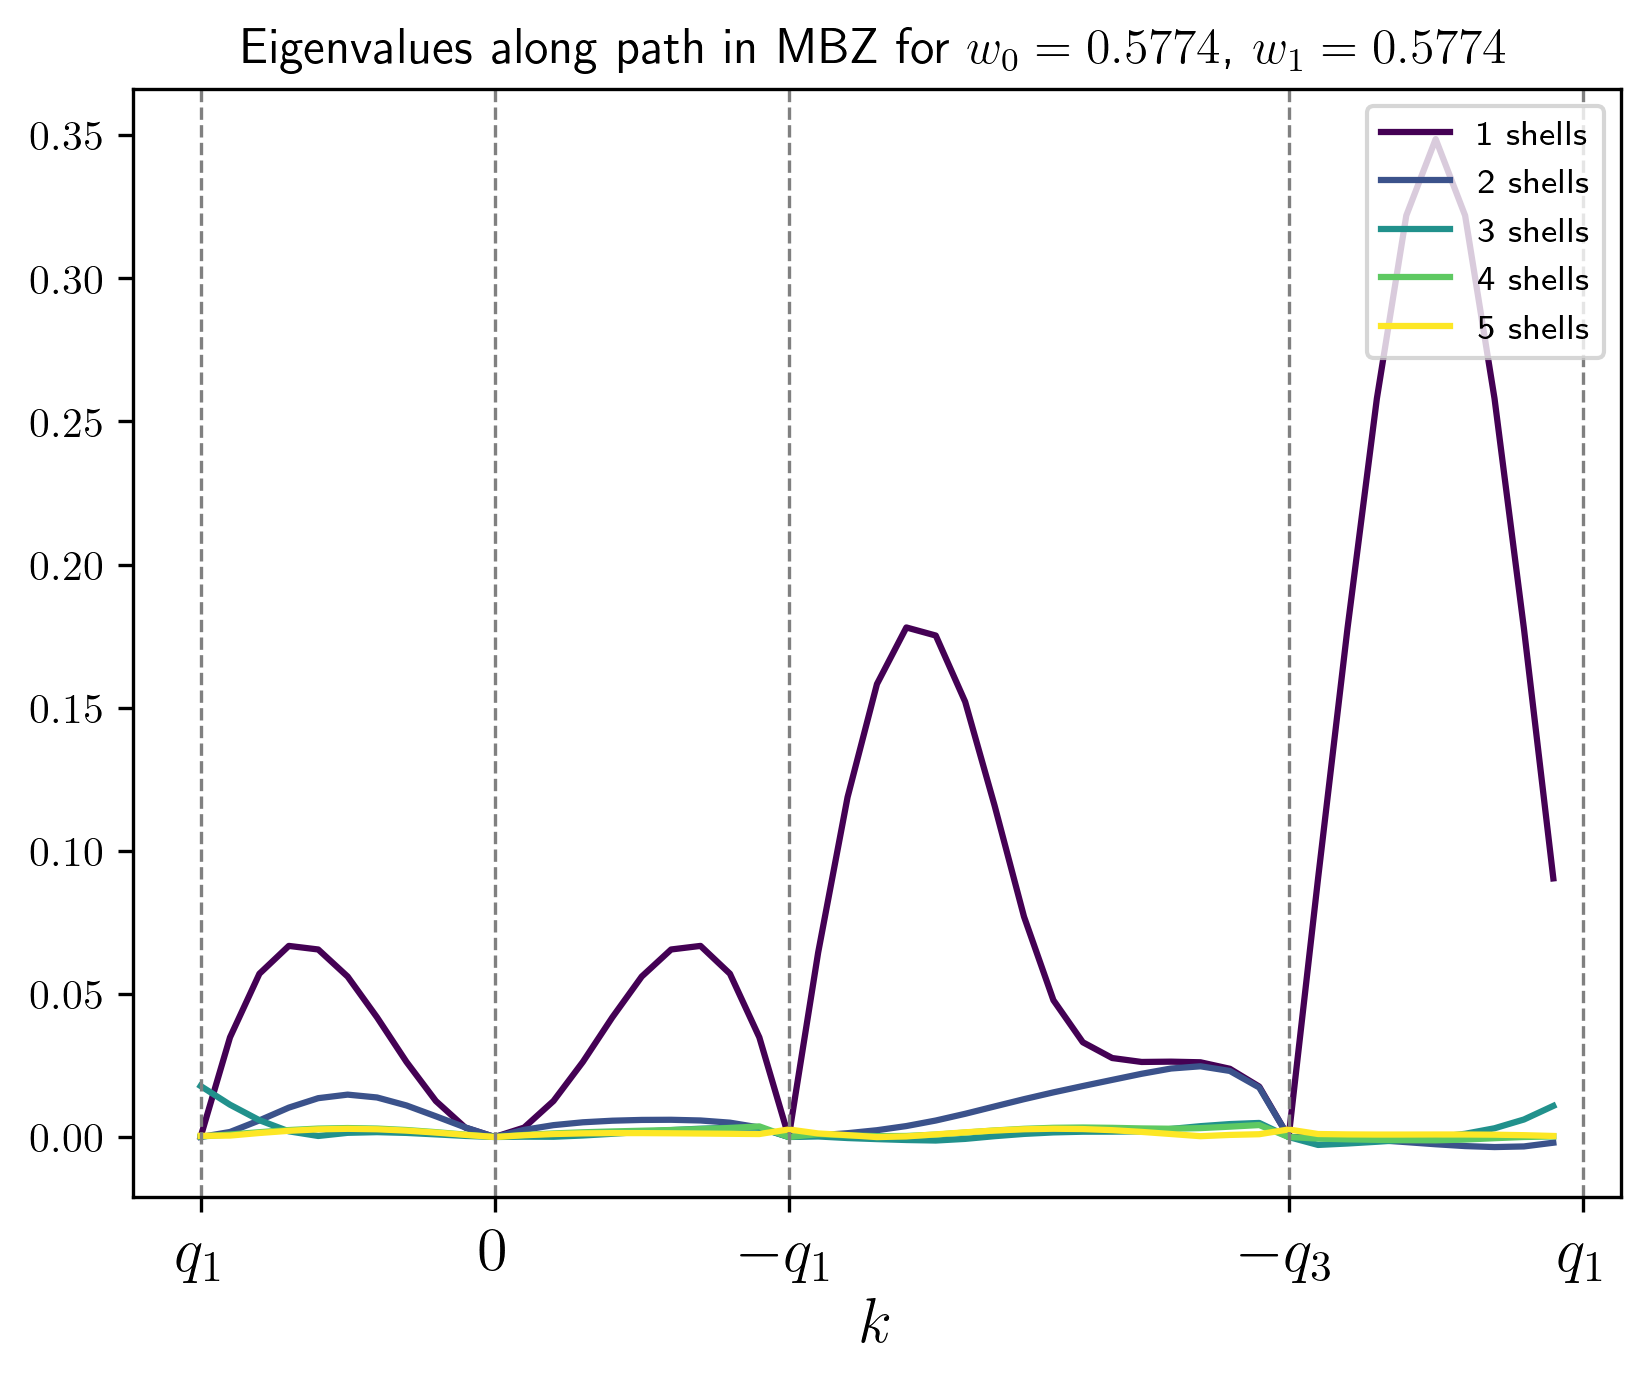

In [289]:
from matplotlib.cm import get_cmap

KM.plot_path_eigvals_colormap(10, 1/sqrt(3), 1/sqrt(3), [1, 2, 3, 4, 5], Elimits=None, bands=(1, 0), colormap='viridis')

In [295]:

points = KM.BZ(60, proportion=2)


all_eigvals = []
for p in tqdm(points):
    all_eigvals.append(np.linalg.eigvalsh(KM.get_KM_matrix(p, 1/sqrt(3), 1/sqrt(3), 6)))

middle_eigvals = [sorted(eigvals)[len(eigvals)//2] for eigvals in all_eigvals]

x = [p[0] for p in points] # + [p[0] for p in points]
y = [p[1] for p in points] # + [p[1] for p in points]
z = middle_eigvals # sixth_eigvals + seventh_eigvals # + second_lowest_eigvals


import plotly.graph_objects as go
# Create a 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color=z, colorscale='Viridis'))])



# Extract coordinates for the vertical line at (x, y) = (0, 1)
line_x = [0, 0]  # x-coordinates of the vertical line
line_y = [0, 0]  # y-coordinates of the vertical line
line_z = [min(z), max(z)]  # z-coordinates span the range of z-values

# Create a 3D scatter plot


fig = go.Figure(data=[
    go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=4, color=z, colorscale='Viridis'),
    ),
    go.Scatter3d(
        x=line_x, y=line_y, z=line_z,
        mode='lines',
        line=dict(color='red', width=4),
        name='Vertical Line'
    )
])

# make the font size of the tickmarks and x y z labels 18
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    font=dict(
                        size=18,
                        color="RebeccaPurple"
                    ))


# Add titles and labels
fig.update_scenes(aspectratio = {'x': sqrt(3)/2, 'y': 1, 'z': 0.5}) # also works for me. Thank you! – 

fig.write_html("surface_plot_asdf.html")

# Show the plot
fig.show()





100%|██████████| 10981/10981 [00:33<00:00, 328.58it/s]


In [294]:

points = KM.BZ(60, proportion=2)


all_eigvals = []
for p in tqdm(points):
    all_eigvals.append(np.linalg.eigvalsh(KM.get_KM_matrix(p, 1/sqrt(3), 1/sqrt(3), 1)))

middle_eigvals = [sorted(eigvals)[len(eigvals)//2] for eigvals in all_eigvals]

x = [p[0] for p in points] # + [p[0] for p in points]
y = [p[1] for p in points] # + [p[1] for p in points]
z = middle_eigvals # sixth_eigvals + seventh_eigvals # + second_lowest_eigvals


import plotly.graph_objects as go
# Create a 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color=z, colorscale='Viridis'))])



# Extract coordinates for the vertical line at (x, y) = (0, 1)
line_x = [0, 0]  # x-coordinates of the vertical line
line_y = [0, 0]  # y-coordinates of the vertical line
line_z = [min(z), max(z)]  # z-coordinates span the range of z-values

# Create a 3D scatter plot


fig = go.Figure(data=[
    go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=4, color=z, colorscale='Viridis'),
    ),
    go.Scatter3d(
        x=line_x, y=line_y, z=line_z,
        mode='lines',
        line=dict(color='red', width=4),
        name='Vertical Line'
    )
])

# make the font size of the tickmarks and x y z labels 18
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    font=dict(
                        size=18,
                        color="RebeccaPurple"
                    ))


# Add titles and labels
fig.update_scenes(aspectratio = {'x': sqrt(3)/2, 'y': 1, 'z': 0.5}) # also works for me. Thank you! – 

fig.write_html("surface_plot_asdf.html")

# Show the plot
fig.show()


100%|██████████| 10981/10981 [00:00<00:00, 11217.03it/s]


In [ ]:

for w in [0.603  + 0.001*i for i in range(11)]:
    KM.plot_path_eigvals_colormap(50, w, w, [2, 3, 4, 5], Elimits=None, bands=(1, 0), colormap='viridis')

In [264]:
from tqdm import tqdm
def test_convergence():
    BZ = KM.BZ(3)
    nshell_list = [1, 2, 3, 4, 5, 6, 7]
    w0 = 1/sqrt(3)
    w1 = 1/sqrt(3)

    nshell_groundtruth = 15
    groundtruth_middle_energies = []
    print("Calculating groundtruth")
    for k in tqdm(BZ):
        H = KM.get_KM_matrix(k, w0, w1, nshell_groundtruth)
        energies = sorted(np.linalg.eigvalsh(H))
        groundtruth_middle_energies.append(energies[len(energies)//2])

    max_errors = []
    for nshell in nshell_list:
        middle_energies = []
        print(f"nshell = {nshell}")
        for k in tqdm(BZ):
            H = KM.get_KM_matrix(k, w0, w1, nshell)
            energies = sorted(np.linalg.eigvalsh(H))
            middle_energies.append(energies[len(energies)//2])
        max_error = max(abs(np.array(groundtruth_middle_energies) - np.array(middle_energies)))
        max_errors.append(max_error)
    
    # Plot log(error) vs nshell
    plt.figure(dpi=300)
    plt.scatter(nshell_list, np.log(max_errors))
    plt.xlabel("Number of shells", fontsize=14)
    plt.ylabel("log(Max error)", fontsize=14)



Calculating groundtruth


100%|██████████| 37/37 [00:34<00:00,  1.06it/s]


nshell = 1


100%|██████████| 37/37 [00:00<00:00, 3767.00it/s]


nshell = 2


100%|██████████| 37/37 [00:00<00:00, 2048.84it/s]


nshell = 3


100%|██████████| 37/37 [00:00<00:00, 1344.03it/s]


nshell = 4


100%|██████████| 37/37 [00:00<00:00, 355.93it/s]


nshell = 5


100%|██████████| 37/37 [00:00<00:00, 435.08it/s]


nshell = 6


100%|██████████| 37/37 [00:00<00:00, 215.14it/s]


nshell = 7


100%|██████████| 37/37 [00:00<00:00, 113.09it/s]


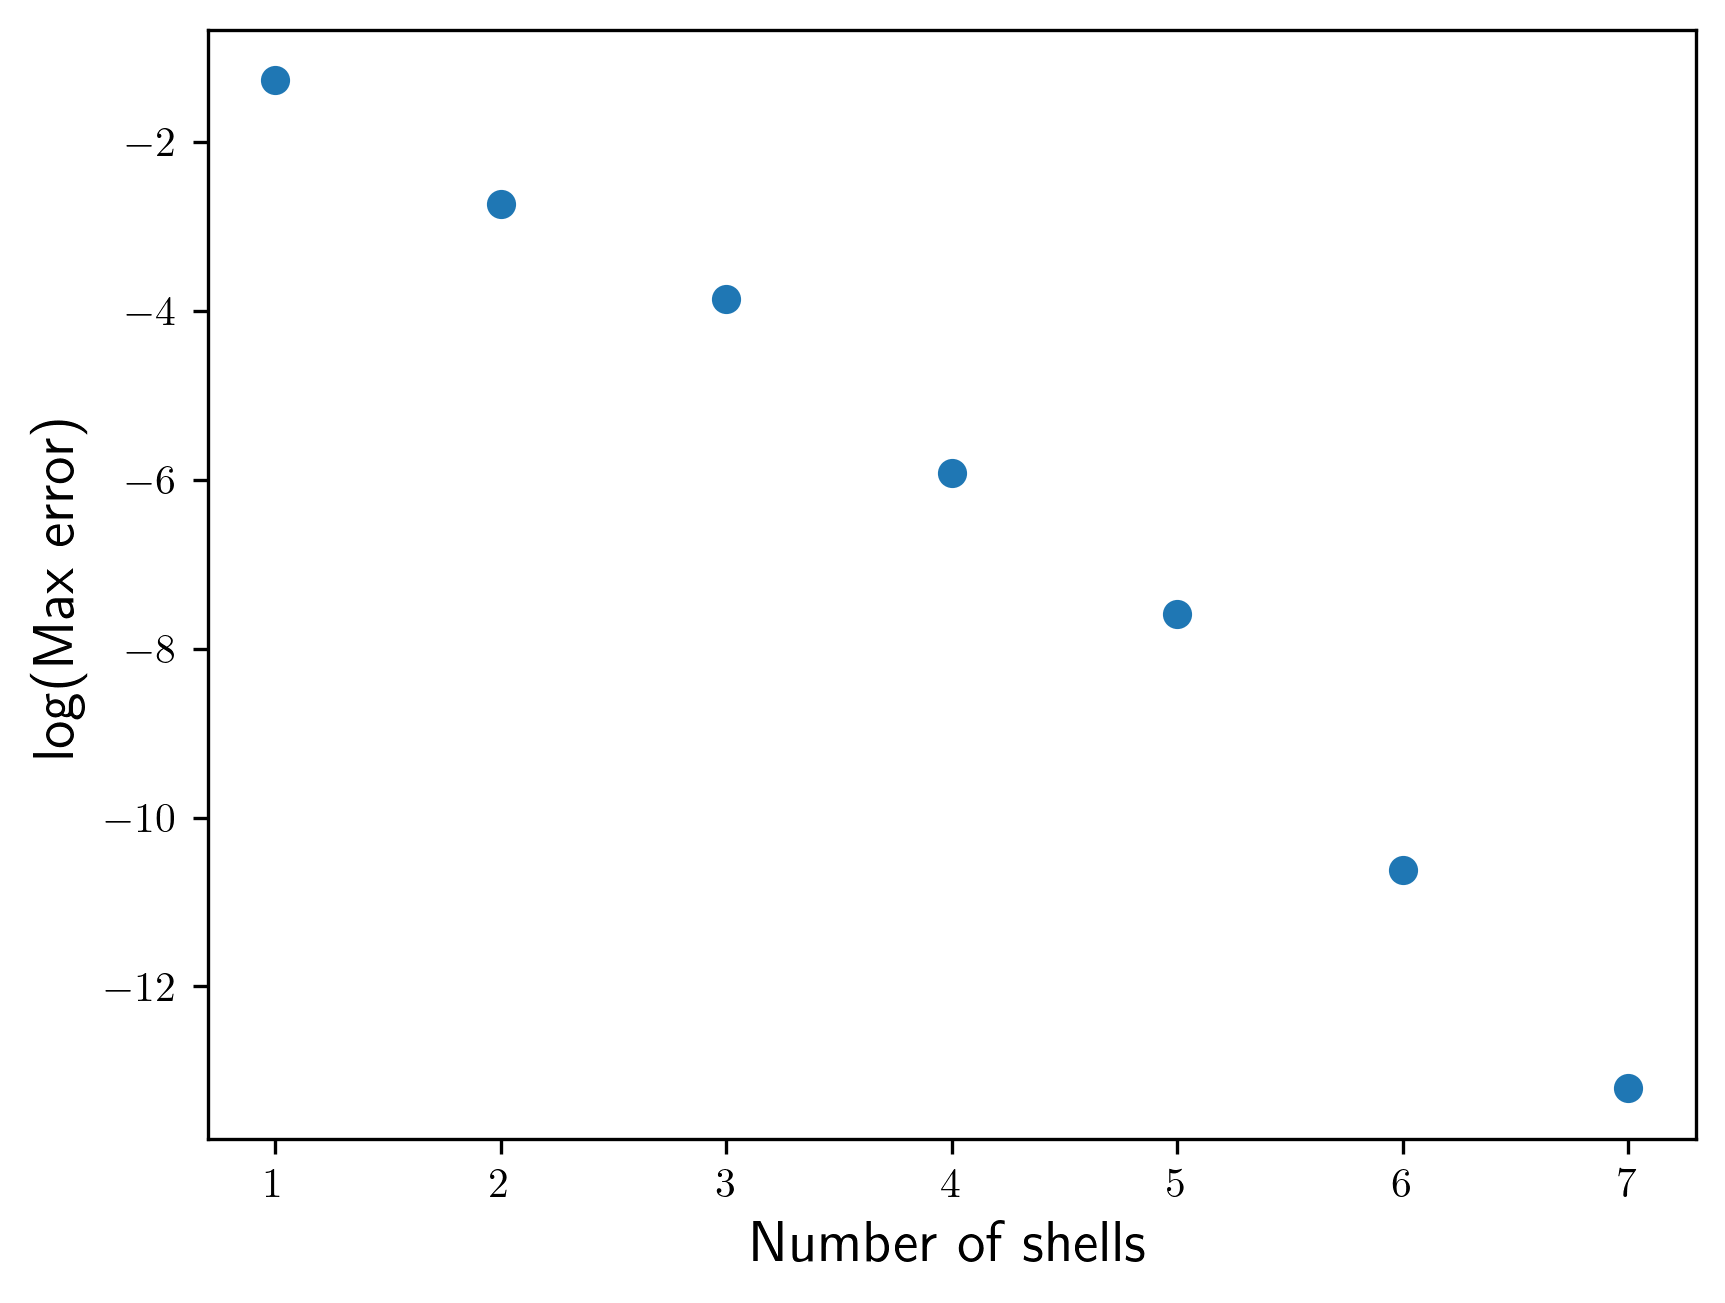

In [265]:
test_convergence()

In [215]:
KM.get_site_index_A(3, 1, 1, 3), KM.get_site_index_A(3, 1, 2, 1)

(34, 34)

In [216]:
# QB_site(n, m, p, n+1)
KM.get_site_index_B(3, 1, 1, 4), KM.get_site_index_B(3, 1, 2, 1)

(50, 50)

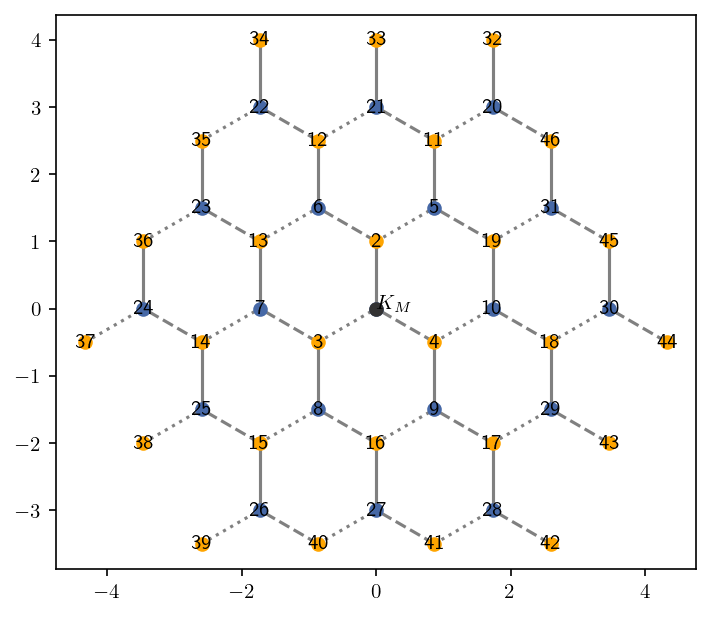

In [205]:
KM.create_site_plot_numbered(5, fontsize=10)

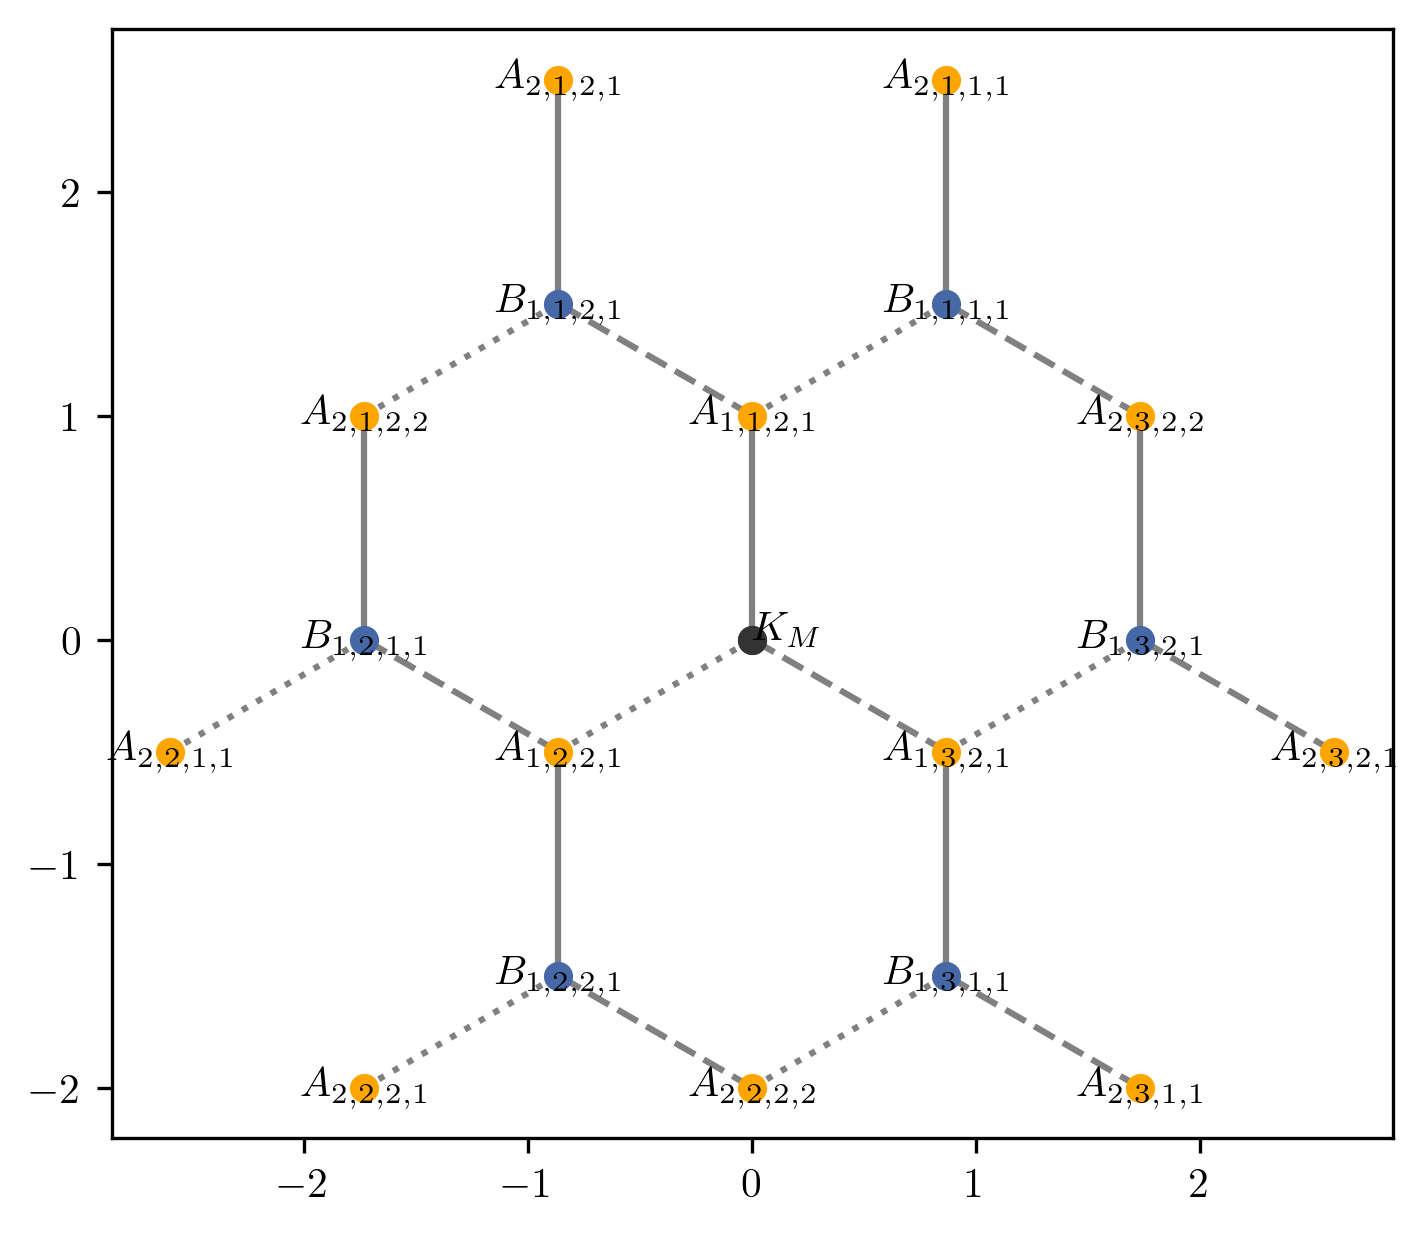

In [172]:
KM.create_site_plot(3, fontsize=10)

In [223]:

def rotate_30i(v, i):
    c = np.cos(i*np.pi/6)
    s = np.sin(i*np.pi/6)
    return np.array([c*v[0] - s*v[1], s*v[0] + c*v[1]])

q1 = np.array([0, 1])

vecs_to_test = [rotate_30i(q1 + np.array([0, 0.1]), 4*i) for i in range(3)]

mats = []
for i in range(3):
    mat = KM.get_KM_matrix(vecs_to_test[i], 1/sqrt(3), 1/sqrt(3), 3)
    mat = KM.get_KM_matrix(vecs_to_test[i], 1/sqrt(3), 1/sqrt(3), 3)
    mats.append(mat)
    print(np.linalg.eigvalsh(mat))

[-4.28223 -4.16497 -3.58844 -3.56505 -3.53051 -2.97396 -2.81302 -2.76532
 -2.5406  -2.44663 -2.04285 -1.87767 -1.78148 -1.23588 -1.15334 -0.87971
 -0.85286 -0.42114 -0.02478  0.02478  0.42114  0.85286  0.87971  1.15334
  1.23588  1.78148  1.87767  2.04285  2.44663  2.5406   2.76532  2.81302
  2.97396  3.53051  3.56505  3.58844  4.16497  4.28223]
[-4.28223 -4.16497 -3.58844 -3.56505 -3.53051 -2.97396 -2.81302 -2.76532
 -2.5406  -2.44663 -2.04285 -1.87767 -1.78148 -1.23588 -1.15334 -0.87971
 -0.85286 -0.42114 -0.02478  0.02478  0.42114  0.85286  0.87971  1.15334
  1.23588  1.78148  1.87767  2.04285  2.44663  2.5406   2.76532  2.81302
  2.97396  3.53051  3.56505  3.58844  4.16497  4.28223]
[-4.28223 -4.16497 -3.58844 -3.56505 -3.53051 -2.97396 -2.81302 -2.76532
 -2.5406  -2.44663 -2.04285 -1.87767 -1.78148 -1.23588 -1.15334 -0.87971
 -0.85286 -0.42114 -0.02478  0.02478  0.42114  0.85286  0.87971  1.15334
  1.23588  1.78148  1.87767  2.04285  2.44663  2.5406   2.76532  2.81302
  2.97396  3

In [213]:

def rotate_30i(v, i):
    c = np.cos(i*np.pi/6)
    s = np.sin(i*np.pi/6)
    return np.array([c*v[0] - s*v[1], s*v[0] + c*v[1]])

q1 = np.array([0, 1])

vecs_to_test = [rotate_30i(q1 + np.array([0, 0.1]), 4*i) for i in range(3)]

mats = []
for i in range(3):
    mat = KM.get_KM_matrix_3(vecs_to_test[i], 1/sqrt(3), 1/sqrt(3), 3)
    mat = KM.get_KM_matrix_3(vecs_to_test[i], 1/sqrt(3), 1/sqrt(3), 3)
    mats.append(mat)
    print(np.linalg.eigvalsh(mat))

[-4.28223 -4.16497 -3.58844 -3.56224 -3.53051 -2.974   -2.81296 -2.74547
 -2.54259 -2.44558 -2.04627 -1.87766 -1.78142 -1.22906 -1.12544 -0.87056
 -0.85397 -0.41791 -0.02401  0.07546  0.5273   0.84643  0.86898  0.94516
  1.15384  1.6023   1.87784  2.06307  2.46775  2.75924  2.76523  2.81739
  2.97408  3.53053  3.56505  3.58845  4.16497  4.28223]
[-4.2783  -4.1669  -3.5886  -3.56505 -3.52986 -2.97261 -2.81361 -2.76532
 -2.54059 -2.44661 -2.04619 -1.87477 -1.78117 -1.23552 -1.15265 -0.8792
 -0.85127 -0.41885 -0.02319  0.02634  0.4214   0.85486  0.8842   1.15352
  1.23583  1.7815   2.04068  2.1933   2.44643  2.53935  2.65906  2.7655
  2.96183  3.02312  3.56504  3.57992  4.27674  4.52166]
[-4.28222 -4.16484 -3.58883 -3.56505 -3.53274 -2.97422 -2.81115 -2.76531
 -2.54057 -2.44665 -2.04283 -1.87666 -1.78145 -1.23611 -1.15302 -0.88056
 -0.85341 -0.41935 -0.00578  0.02303  0.41946  0.86549  1.06244  1.19702
  1.27357  1.78255  1.87766  2.04098  2.11767  2.46586  2.54641  2.81294
  2.97393  3.5

In [44]:

q1 = np.array([0, 1])
q2 = np.array([-sqrt(3)/2, -1/2])
q3 = np.array([sqrt(3)/2, -1/2])

def rotate_60i(v, i):
    c = np.cos(i*np.pi/3)
    s = np.sin(i*np.pi/3)
    return np.array([c*v[0] - s*v[1], s*v[0] + c*v[1]])

def dotsigma(v):
    sigmax = np.array([[0, 1], [1, 0]])
    sigmay = np.array([[0, -1j], [1j, 0]])
    return v[0] * sigmax + v[1] * sigmay

def Tj(j, w0, w1):
    # The T matrices in BSRL are hermitian.
    sigma0 = np.identity(2)
    sigmax = np.array([[0, 1], [1, 0]])
    sigmay = np.array([[0, -1j], [1j, 0]])
    return w0 * sigma0 + w1 * (np.cos(2*np.pi*(j-1)/3) * sigmax + np.sin(2*np.pi*(j-1)/3) * sigmay)

In [50]:
def tripod(k, w0, w1):
    mat = np.zeros((8, 8), dtype = complex)
    mat[0:2, 0:2] = dotsigma(k)
    mat[2:4, 2:4] = dotsigma(k-q1)
    mat[4:6, 4:6] = dotsigma(k-q2)
    mat[6:8, 6:8] = dotsigma(k-q3)

    T1 = Tj(1, w0, w1)
    T2 = Tj(2, w0, w1)
    T3 = Tj(3, w0, w1)
    mat[0:2, 2:4] = T1
    mat[2:4, 0:2] = T1
    mat[0:2, 4:6] = T2
    mat[4:6, 0:2] = T2
    mat[0:2, 6:8] = T3
    mat[6:8, 0:2] = T3
    return mat

In [31]:
from matplotlib import cm

def replicate_BM_fig3(N, theta, nshell, ax=None, Elimits=None, bands=(7, 7)):
    # N is the N used when creating the eigenvalue lists along the path
    # w0, w1 are the parameters in the Hamiltonian
    # nshell is the number of shells of hopping sites
    # Elimits is a tuple (Emin, Emax) that sets the y-axis limits
    # bands is a two-tuple (num_bands_above, num_bands_below) that sets the number of bands to plot above and below the Fermi level



    import matplotlib.pyplot as plt
    if ax is None:
        fig, ax = plt.subplots(dpi=150)


    w = 0.005294 / np.sin(np.pi * (theta/2) / 180)
    print('w: ', w)
    w0 = w
    w1 = w

    # In BM paper, they go from q1 to 0 to -q1 to -q3 to q1
    q1 = np.array([0, 1])
    q2 = np.array([-sqrt(3)/2, -1/2])
    q3 = np.array([sqrt(3)/2, -1/2])

    path = []
    for i in range(N):
        path.append((1-i/N)*q1 + (i/N)*0)
    for i in range(N):
        path.append((1-i/N)*0 + (i/N)*(-q1))
    for i in range(int(N*sqrt(3))):
        path.append((1-i/(N*sqrt(3)))*(-q1) + (i/(N*sqrt(3)))*(-q3))
    for i in range(N):
        path.append((1-i/N)*(-q3) + (i/N)*q1)
    

    all_eigvals = []
    for k in path:
        all_eigvals.append(sorted(np.linalg.eigvalsh(KM.get_KM_matrix(k, w0, w1, nshell))))
        
    total_num_bands = len(all_eigvals[0])
    if bands:
        which_eigvals_to_plot = range(total_num_bands//2 - bands[1], total_num_bands//2 + bands[0])
    else: 
        which_eigvals_to_plot = range(total_num_bands)
    eigvals_to_plot = np.array(all_eigvals)[:, which_eigvals_to_plot]


    if Elimits:
        ax.set_ylim(Elimits)

    cmap = cm.get_cmap('tab20', len(eigvals_to_plot[0]))

    for i in range(len(eigvals_to_plot[0])):
        ax.plot(eigvals_to_plot[:, i], color=cmap(i))# , label=f'Band {i + 1}')

    # for i in range(len(eigvals_to_plot[0])):
    #     ax.plot(eigvals_to_plot[:, i], color='blue')
    
    k_labels = ["$q_1$", "$0$", "$-q_1$", "$-q_3$", "$q_1$"]
    k_points = [0, N, 2*N, 2*N+int(N*sqrt(3)), 3*N + int(N*sqrt(3))]

    ax.set_xticks(k_points)
    ax.set_xticklabels(k_labels)
    ax.set_xlabel("$k$")
    ax.set_ylabel("$E$")
    
    # Add dashed vertical lines for labeled points
    for k in k_points:
        ax.axvline(k, color='gray', linestyle='dashed', linewidth=0.8)

    ax.title.set_text(f"Eigenvalues along path in MBZ for $w_0 = {w0:.3f}$, $w_1 = {w1:.3f}$, $n_{{\\text{{shell}}}} = {nshell}$")

    plt.show()

w:  0.5777678120087318


/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_18922/3450483674.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(eigvals_to_plot[0]))


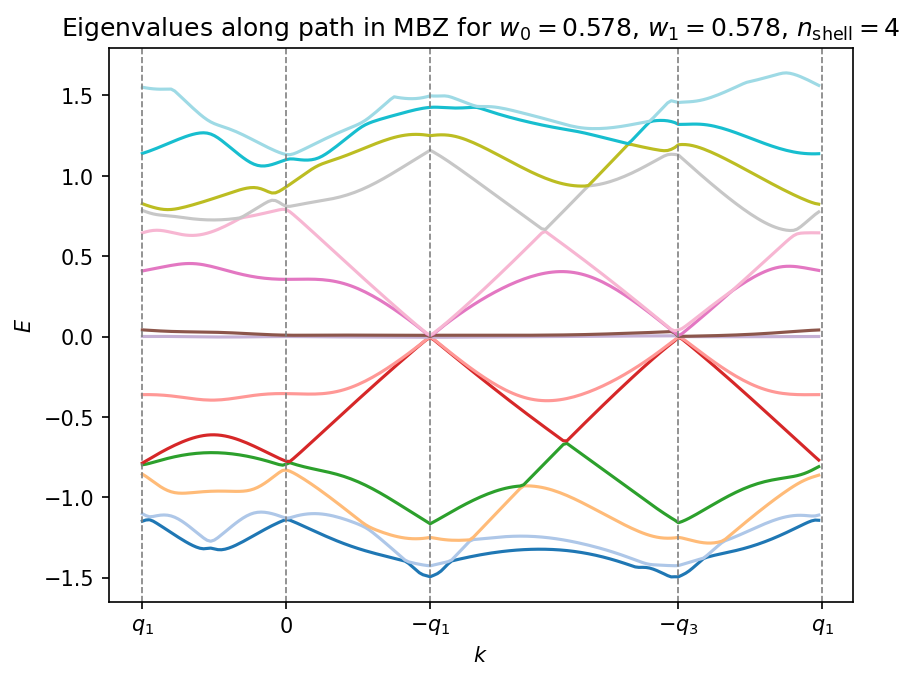

In [37]:
replicate_BM_fig3(40, 1.05, 4, ax=None, Elimits=None, bands=(7,7))

w:  0.12136805030432643


/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_18922/3450483674.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(eigvals_to_plot[0]))


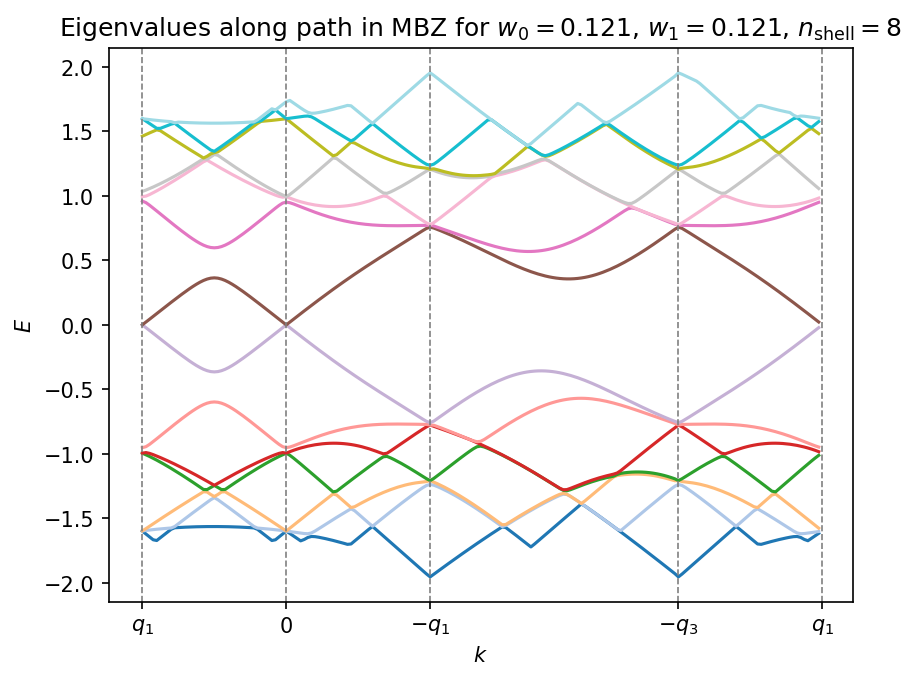

w:  0.5777678120087318


/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_18922/3450483674.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(eigvals_to_plot[0]))


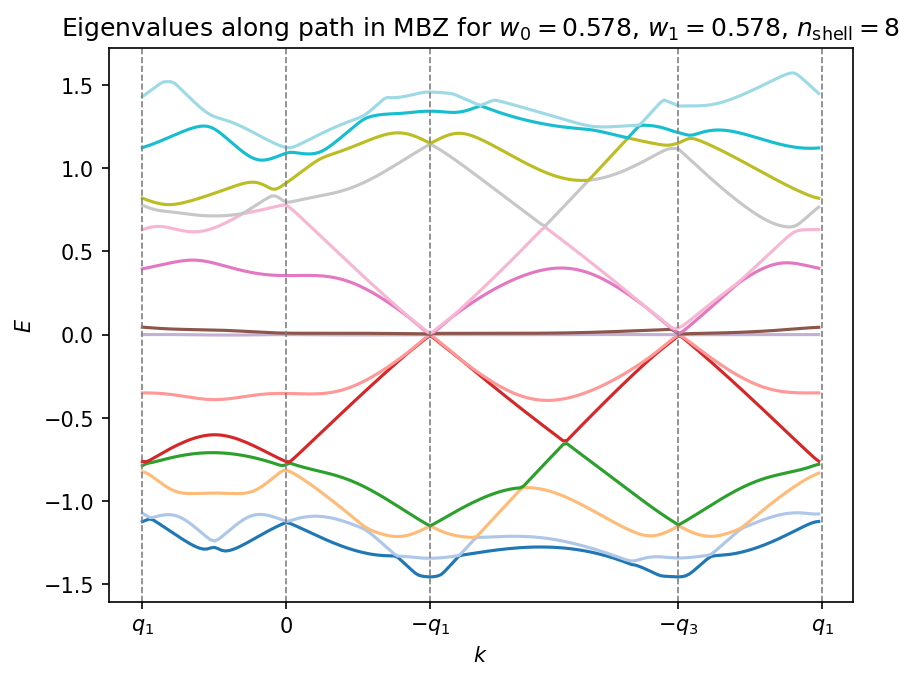

w:  1.2132992768830242


/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_18922/3450483674.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(eigvals_to_plot[0]))


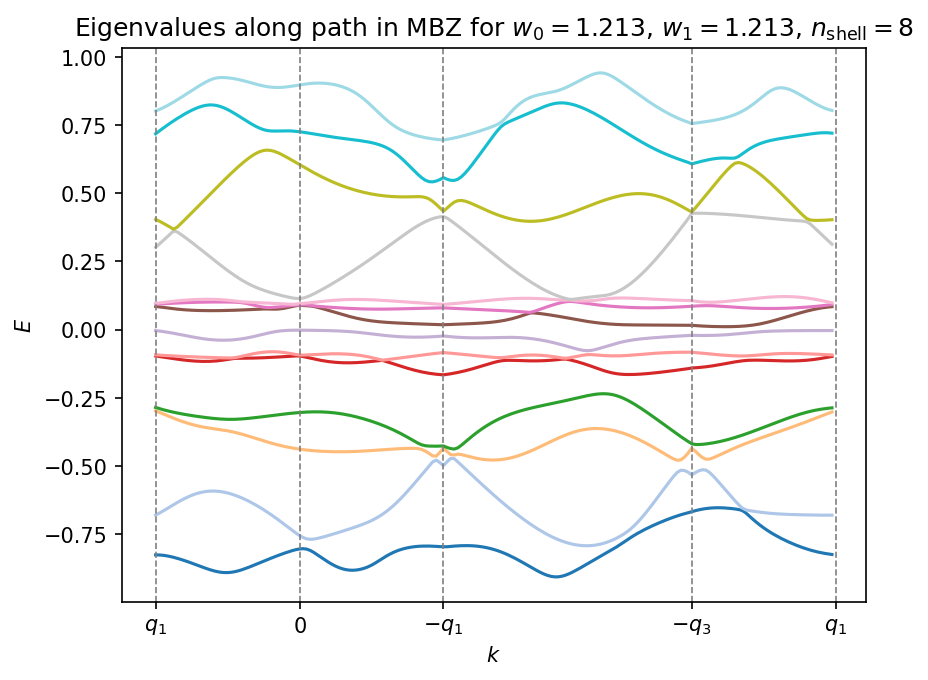

In [38]:
replicate_BM_fig3(40, 5.0, 8, ax=None, Elimits=None, bands=(7,7))
replicate_BM_fig3(40, 1.05, 8, ax=None, Elimits=None, bands=(7,7))
replicate_BM_fig3(40, 0.5, 8, ax=None, Elimits=None, bands=(7,7))

In [56]:

def replicate_BM_fig3(N, thetas, nshell, Elimits=None, bands=(7, 7)):
    # N is the N used when creating the eigenvalue lists along the path
    # thetas is a list of three theta values
    # nshell is the number of shells of hopping sites
    # Elimits is a tuple (Emin, Emax) that sets the y-axis limits
    # bands is a two-tuple (num_bands_above, num_bands_below) that sets the number of bands to plot above and below the Fermi level

    fig, axes = plt.subplots(1, 3, dpi=300, figsize=(6, 5), sharey=True)

    for idx, (theta, ax) in enumerate(zip(thetas, axes)):
        w = 0.005294 / np.sin(np.pi * (theta / 2) / 180)
        w0 = w
        w1 = w

        # In BM paper, they go from q1 to 0 to -q1 to -q3 to q1
        q1 = np.array([0, 1])
        q2 = np.array([-sqrt(3) / 2, -1 / 2])
        q3 = np.array([sqrt(3) / 2, -1 / 2])

        path = []
        for i in range(N):
            path.append((1 - i / N) * q1 + (i / N) * 0)
        for i in range(N):
            path.append((1 - i / N) * 0 + (i / N) * (-q1))
        for i in range(int(N * sqrt(3))):
            path.append((1 - i / (N * sqrt(3))) * (-q1) + (i / (N * sqrt(3))) * (-q3))
        for i in range(N):
            path.append((1 - i / N) * (-q3) + (i / N) * q1)

        all_eigvals = []
        for k in path:
            all_eigvals.append(sorted(np.linalg.eigvalsh(KM.get_KM_matrix(k, w0, w1, nshell))))

        total_num_bands = len(all_eigvals[0])
        if bands:
            which_eigvals_to_plot = range(total_num_bands // 2 - bands[1], total_num_bands // 2 + bands[0])
        else:
            which_eigvals_to_plot = range(total_num_bands)
        eigvals_to_plot = np.array(all_eigvals)[:, which_eigvals_to_plot]

        if Elimits:
            ax.set_ylim(Elimits)

        cmap = cm.get_cmap('tab20', len(eigvals_to_plot[0]))

        for i in range(len(eigvals_to_plot[0])):
            ax.plot(eigvals_to_plot[:, i], color=cmap(i), lw=2.5)

        k_labels = ["$q_1$", "$0$", "$-q_1$", "$-q_3$", "$q_1$"]
        k_points = [0, N, 2 * N, 2 * N + int(N * sqrt(3)), 3 * N + int(N * sqrt(3))]

        ax.set_xticks(k_points)
        ax.set_xticklabels(k_labels, fontsize=15)
        ax.set_xlabel("$k$", fontsize=15)
        if idx == 0:
            ax.set_ylabel("$E$", fontsize=15)

        # Add dashed vertical lines for labeled points
        for k in k_points:
            ax.axvline(k, color='gray', linestyle='dashed', linewidth=0.8)

        ax.text(0.5, 1.02, fr"$\theta = {theta}$", transform=ax.transAxes, ha="center", fontsize=20)

    plt.tight_layout()
    plt.savefig("moire_bands.png", dpi=300, bbox_inches='tight')
    plt.show()


/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_18922/907333907.py:44: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_18922/907333907.py:44: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_18922/907333907.py:44: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



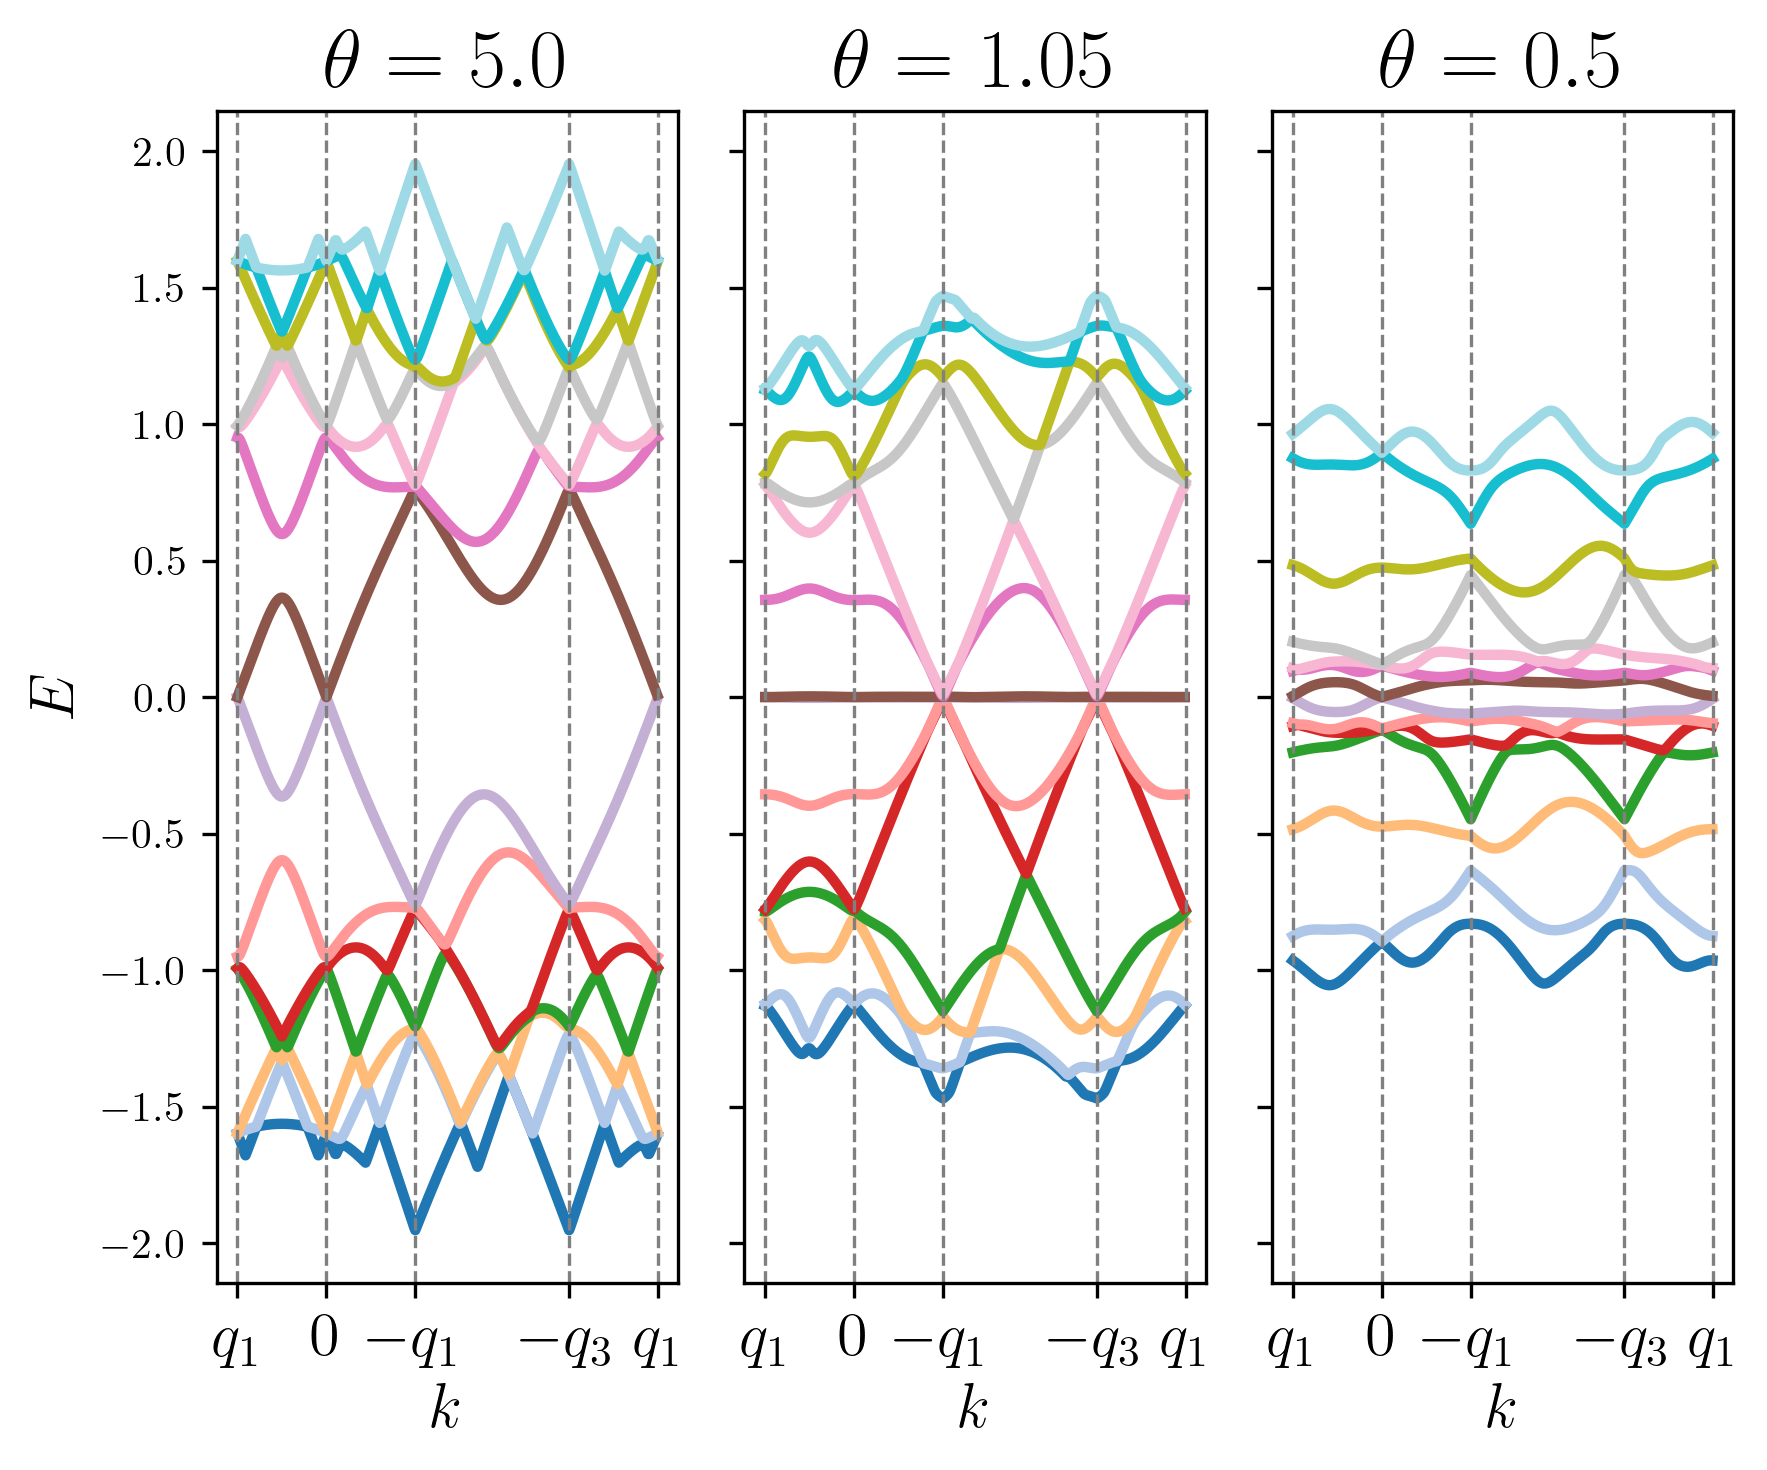

In [225]:
import matplotlib.pyplot as plt
replicate_BM_fig3(100, [5.0, 1.05, 0.5], 5, Elimits=None, bands=(7, 7))

In [ ]:
def replicate_BM_fig3_dos()

In [81]:


def BZ(N, proportion=1):
    # Generates a list of points within the MBZ.
    # Creates a point at the center, six at the corners,
    # and has N points between the center and each corner, including the corner and excluding the center.
    # The hexagonal BZ is oriented with pointy ends up and down, following the convention in BSRL1.abs
    # proportion > 1 scales the region so that it covers more than just the MBZ. proportion < 1 zooms in on Gamma_M

    # First, generate the points in a sextant. Then, make five more copies. 
    # Starting with the eastern sextant. 

    assert N >= 1

    q1N = np.array([0, 1]) / N * proportion
    q3N = np.array([sqrt(3)/2, -1/2]) / N * proportion

    east_points = []
    for i in range(1, N+1):
        for j in range(i):
            east_points.append(i*q3N + j*q1N)


    all_points = [np.array([0, 0])]
    # Now making the other copies.
    def rotate_60ccw(v):
        c = np.cos(np.pi/3)
        s = np.sin(np.pi/3)
        return np.array([c*v[0] - s*v[1], s*v[0] + c*v[1]])

    for point in east_points:
        all_points.append(point)
        for i in range(5):
            all_points.append(rotate_60ccw(all_points[-1]))
    
    return all_points









def replicate_BM_fig3_dos(N, thetas, nshell, Elimits=None, yscales=None):
    # N is the N used when creating the eigenvalue lists along the path
    # thetas is a list of three theta values
    # nshell is the number of shells of hopping sites
    # Elimits is a tuple (Emin, Emax) that sets the y-axis limits
    # yscales is a list of y-axis scales for each subplot (e.g., 'linear', 'log', etc.)

    import matplotlib.pyplot as plt
    import numpy as np
    from math import sqrt

    fig, axes = plt.subplots(1, 3, dpi=300, figsize=(6, 2), sharey=False)

    for idx, (theta, ax) in enumerate(zip(thetas, axes)):
        w = 0.005294 / np.sin(np.pi * (theta / 2) / 180)
        w0 = w
        w1 = w

        # In BM paper, they go from q1 to 0 to -q1 to -q3 to q1
        q1 = np.array([0, 1])
        q2 = np.array([-sqrt(3) / 2, -1 / 2])
        q3 = np.array([sqrt(3) / 2, -1 / 2])

        kpoints = BZ(N, proportion=1.5)

        all_eigvals = []
        for k in kpoints:
            all_eigvals.append(sorted(np.linalg.eigvalsh(KM.get_KM_matrix(k, w0, w1, nshell))))

        bands = (4, 4)
        total_num_bands = len(all_eigvals[0])
        if bands:
            which_eigvals = range(total_num_bands // 2 - bands[1], total_num_bands // 2 + bands[0])
        else:
            which_eigvals = range(total_num_bands)

        eigenvalues = np.array(all_eigvals)[:, which_eigvals].flatten()

        # If no energy range is provided, determine it from eigenvalues
        energy_range = (eigenvalues.min(), eigenvalues.max())

        # Compute histogram
        dos_counts, bin_edges = np.histogram(eigenvalues, bins=400, range=energy_range, density=False)
        bin_width = bin_edges[1] - bin_edges[0]

        # Normalize DOS
        dos = dos_counts / (len(eigenvalues) * bin_width)
        energies = (bin_edges[:-1] + bin_edges[1:]) / 2  # Bin centers

        ax.plot(energies, dos, color='blue', lw=1.5)

        # Set y-axis scale for this subplot
        if yscales and idx < len(yscales):
            ax.set_yscale(yscales[idx])

        # Optional: Set y-axis limits
        if Elimits:
            ax.set_ylim(Elimits)
        
        ax.text(0.5, 1.02, fr"$\theta = {theta}$", transform=ax.transAxes, ha="center", fontsize=12)

    plt.tight_layout()
    plt.savefig("dos.png", dpi=300, bbox_inches='tight')
    plt.show()


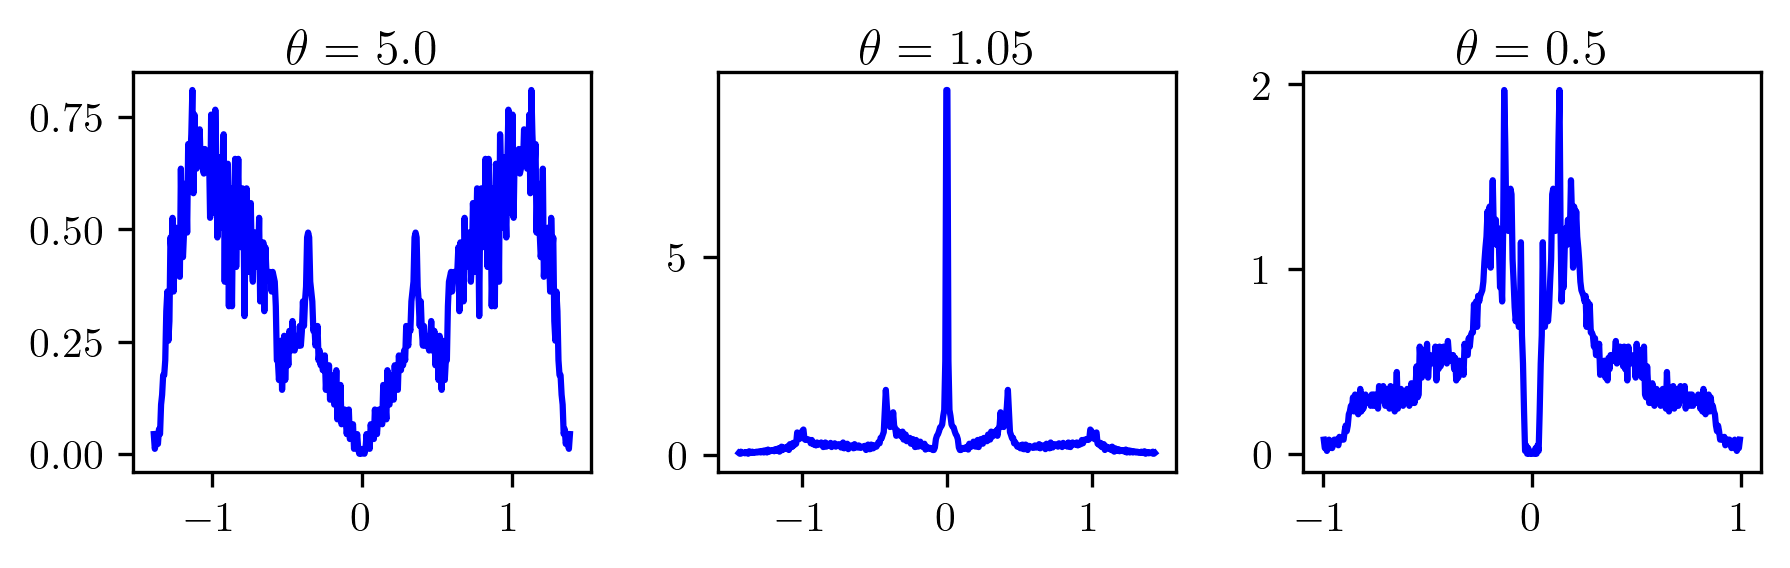

In [224]:
replicate_BM_fig3_dos(40, (5.0, 1.05, 0.5), 3, Elimits=None)

In [274]:
from scipy.stats import linregress
from tqdm import tqdm
def replicate_BM_fig4(nshell):
    thetamin = 0.18
    thetamax = 1.2
    alphamin = 0.005294 / np.sin(np.pi * (thetamax / 2) / 180)
    alphamax = 0.005294 / np.sin(np.pi * (thetamin / 2) / 180)
    # alphamax = sqrt(5)

    alphasquaredmin = alphamin**2
    alphasquaredmax = alphamax**2

    alphasquared_range = np.linspace(alphasquaredmin, alphasquaredmax, 200)
    alpha_range = np.sqrt(alphasquared_range)

    def get_v(alpha):
        eigvals_vs_k = []
        # kvals = [0.001*i for i in range(20)]
        dk = 0.0001
        kvals = [(dk*np.cos(i*np.pi/180), dk*np.sin(i*np.pi/180)) for i in range(0, 360, 180)]
        for k in kvals:
            # k = [0, ky]
            eigvals = np.linalg.eigvalsh(KM.get_KM_matrix(k, alpha, alpha, nshell))
            zero_band = eigvals[len(eigvals)//2]
            eigvals_vs_k.append(zero_band)
        eigvals_vs_k = np.array(eigvals_vs_k)
        slopes = []
        k0_eigvals = np.linalg.eigvalsh(KM.get_KM_matrix([0, 0], alpha, alpha, nshell))
        k0_eigval = k0_eigvals[len(k0_eigvals)//2]
        return np.abs(np.mean((eigvals_vs_k - k0_eigval)/dk))

    slopes = []
    for alpha in tqdm(alpha_range):
        slopes.append(get_v(alpha))

    fig, ax = plt.subplots(dpi=300)
    ax.plot(alphasquared_range, slopes, color='blue', lw=2)
    ax.set_xlabel(r"$\alpha^2$")
    ax.set_ylabel(r"$v$")
    plt.show()

100%|██████████| 200/200 [01:27<00:00,  2.28it/s]


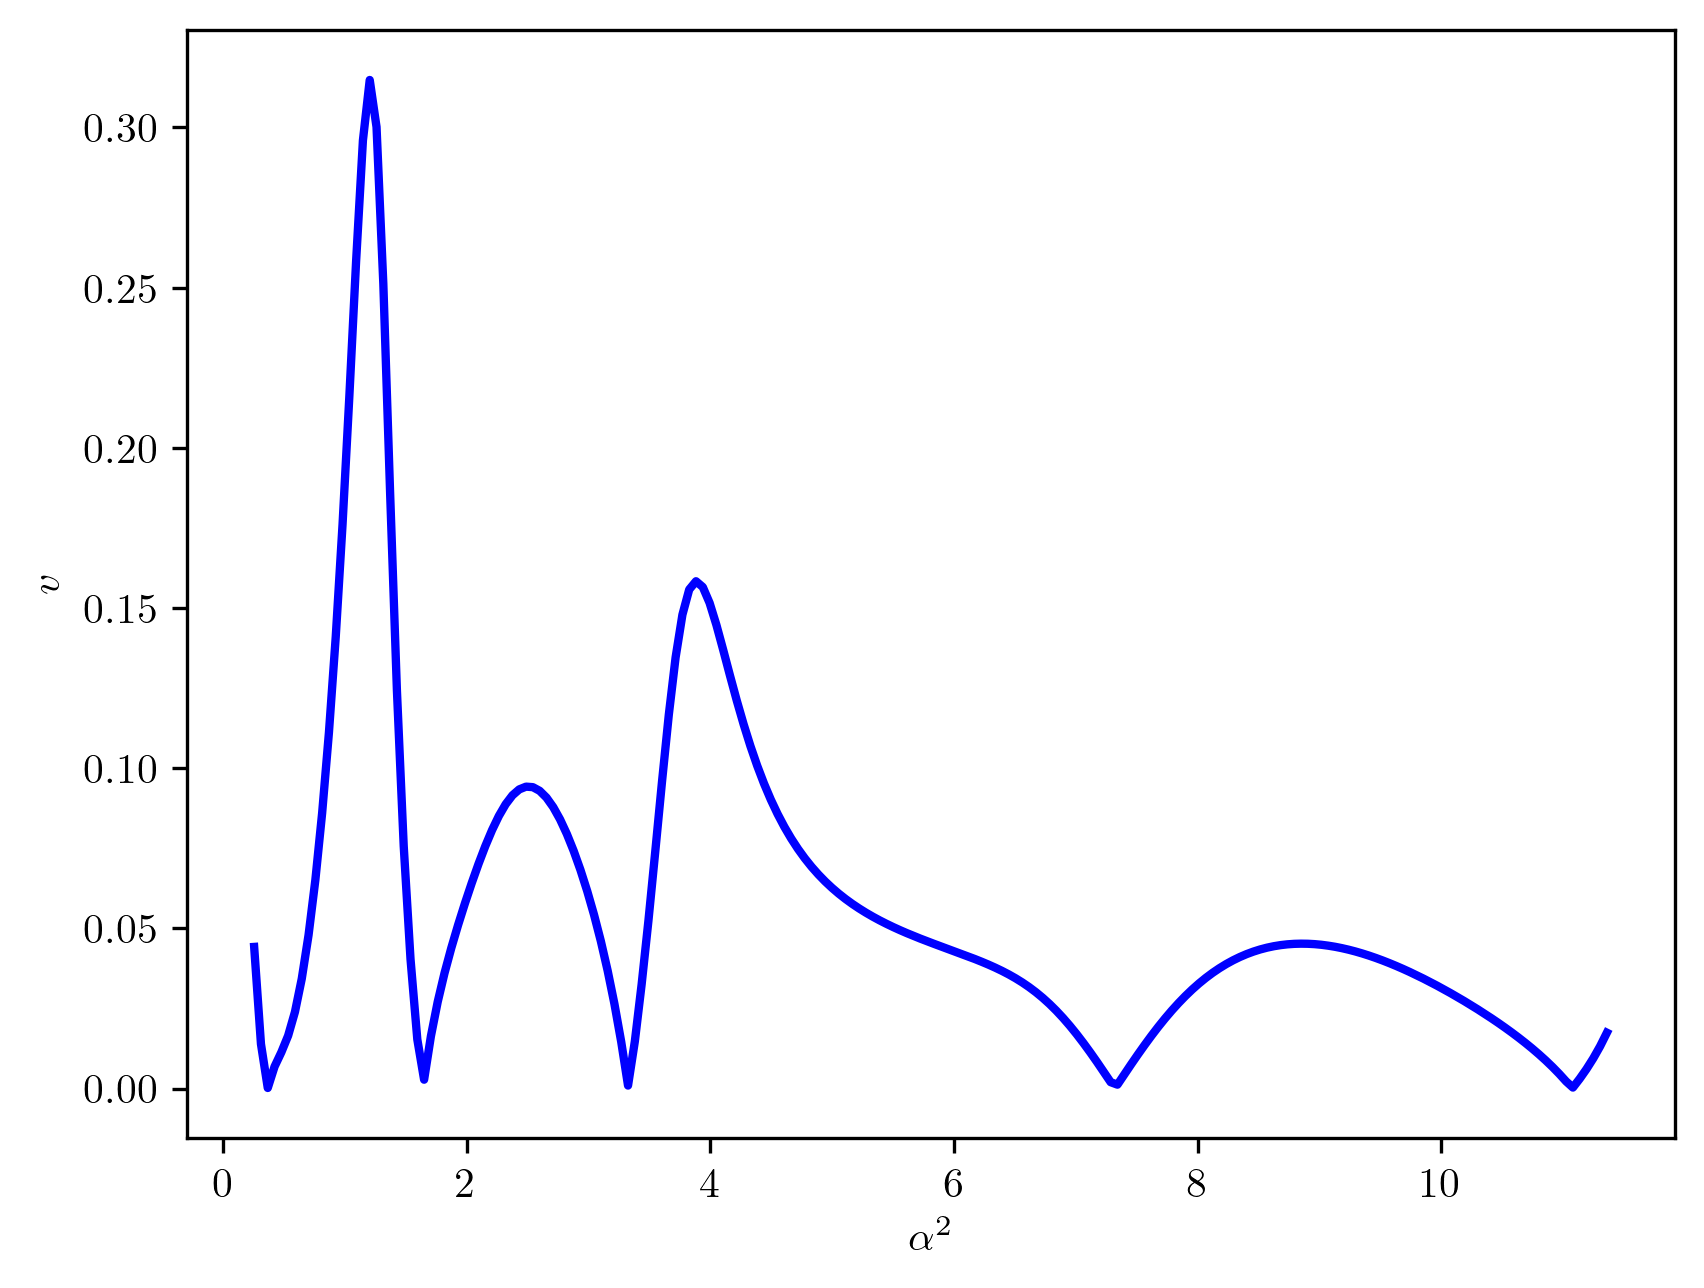

In [277]:
replicate_BM_fig4(14)

In [239]:
points = [(kx, ky) for kx in np.linspace(-2, 2, 100) for ky in np.linspace(-2, 2, 100)]

all_eigvals = []
for k in points:
    all_eigvals.append(sorted(np.linalg.eigvalsh(KM.get_KM_matrix(k, 1/sqrt(3), 1/sqrt(3), 6))))

bands = (1, 0)
total_num_bands = len(all_eigvals[0])
if bands:
    which_eigvals = range(total_num_bands // 2 - bands[1], total_num_bands // 2 + bands[0])
else:
    which_eigvals = range(total_num_bands)

eigenvalues = np.array(all_eigvals)[:, which_eigvals].flatten()

x = [p[0] for p in points]
y = [p[1] for p in points] 
z = eigenvalues

import plotly.graph_objects as go
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color=z, colorscale='Viridis'))])

# Label the x axis as $k_x a$
# fig.update_layout(
#     scene=dict(
#         xaxis=dict(
#             title="k<sub>x</sub> a",
#             title_font=dict(size=20),  # Font size for x-axis title
#             tickfont=dict(size=15)    # Font size for x-axis tick labels
#         ),
#         yaxis=dict(
#             title="k<sub>y</sub> a",
#             title_font=dict(size=20),  # Font size for y-axis title
#             tickfont=dict(size=15)    # Font size for y-axis tick labels
#         ),
#         zaxis=dict(
#             title="E",
#             title_font=dict(size=20),  # Font size for z-axis title
#             tickfont=dict(size=15)    # Font size for z-axis tick labels
#         )
#     )
# )

# Add titles and labels
# fig.update_scenes(aspectratio = {'x': sqrt(3)/2, 'y': 1, 'z': 0.5}) # also works for me. Thank you! – 

fig.write_html("surface_plot_flat.html")

# Show the plot
fig.show()

In [104]:
a = np.linalg.eigvalsh(KM.get_KM_matrix([6, 6], 1/sqrt(3), 1/sqrt(3), 13))
print(a[len(a)//2 - 1: len(a)//2 + 1])

[-0.04439  0.0144 ]
